# Figure9: Visualize AI workers' confusion matrix

In [1]:
import polars as pl
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from matplotlib import pyplot as plt
from crowdkit.aggregation import DawidSkene
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def plot_confusion_matrix(cm, class_names, output_file_path, font_size=10):
    fig, ax = plt.subplots(figsize=(3, 4))
    cm = np.array(cm, dtype=np.float32)
    im = ax.matshow(cm, cmap="YlGnBu", )
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "white" if cm[i, j] > 50 else "black"
            ax.text(j, i, format(cm[i, j], '.0f'),
                    ha="center", va="center",
                    color=text_color, fontsize=font_size)
    plt.tight_layout(rect=[0, 0, 1, 1])  # 端が切れないようにレイアウトを調整
    
    ax.tick_params(axis='x', top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_xticks(np.arange(len(class_names))) 
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, ha='center') 
    ax.set_yticklabels(class_names, va='center')
    im.set_clim(0, 150)  # カラーバーの範囲を0から1に統一
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    fig.colorbar(im, cax=cax)

    plt.savefig(output_file_path, bbox_inches='tight')
    plt.show()
    plt.close()


In [4]:
class_labels = {
    0: "section 230",
    1: "trump ban",
    2: "twitter support",
    3: "platform polices",
    4: "complaint",
    5: "other",
}

**Human Data**
The number of workers per tasks ($r$)=2

In [6]:
human = pl.read_csv("datasets/human.csv")
human.unique("task").group_by("gt").agg(pl.count()).sort("gt")

/tmp/ipykernel_1327/1929939955.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  human.unique("task").group_by("gt").agg(pl.count()).sort("gt")


gt,count
i64,u32
0,147
1,80
2,3
3,25
4,52


In [7]:
human["worker"].unique().count()

22

In [8]:
human["task"].unique().count()

307

In [9]:
human["label"].count()

614

Accuracy: 0.8273615635179153


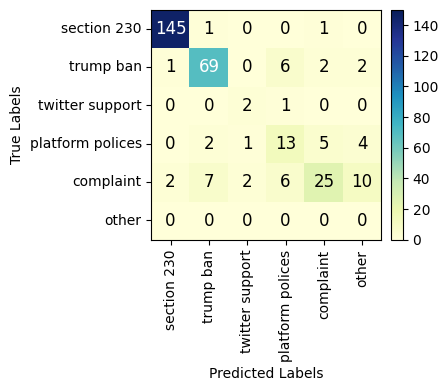

In [55]:
## Human Confusion matrix (Dawid-Skene)
human_pd = human.to_pandas()
gt = human_pd.filter(["task","gt"]).drop_duplicates(keep='last').set_index("task")
human_pd = human_pd.drop(["gt"], axis=1)
ret = DawidSkene().fit_predict(human_pd)
y_true = gt.sort_index().astype(str)
y_pred = ret.sort_index().astype(str)
cm = confusion_matrix(y_true, y_pred, labels=["0","1","2","3","4","5"])
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")
plot_confusion_matrix(cm, 
                      class_names=list(class_labels.values()), 
                      output_file_path="exp2_ds1task5_human_cm.svg", 
                      font_size=12)

**AI Data**

 - `f100` FLAN-T5 100 samples
 - `g100` GPT3.5 100 samples
 - `l250` llma-70b 250 samples


Accuracy of f100 model: 0.8241042345276873


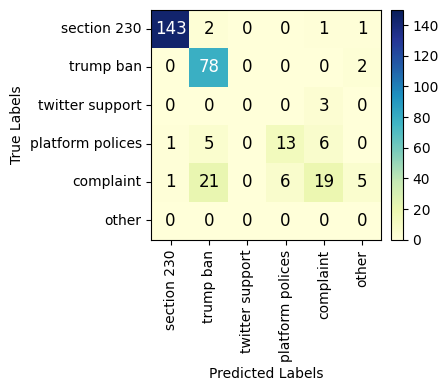

Accuracy of g100 model: 0.749185667752443


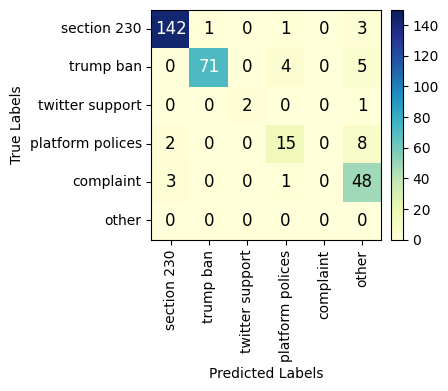

Accuracy of l250 model: 0.7817589576547231


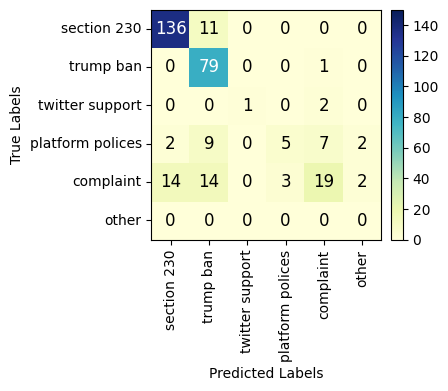

In [56]:
f100 = pl.read_csv("datasets/f100.csv")
g100 = pl.read_csv("datasets/g100.csv")
l250 = pl.read_csv("datasets/l250.csv")

for df, name in zip([f100, g100, l250], ["f100", "g100", "l250"]):
    cm = confusion_matrix(df["gt"], df["label"], labels=[0,1,2,3,4,5])
    accuracy = accuracy_score(df["gt"], df["label"])
    print(f"Accuracy of {name} model: {accuracy}")
    plot_confusion_matrix(cm, 
                          class_names=list(class_labels.values()), 
                          output_file_path=f"exp2_ds1task5_{name}_cm.svg", 
                          font_size=12)